In [26]:
import requests
import pandas as pd
import numpy as np

user_agent = {'User-agent': 'Mozilla/5.0'}

url = 'https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations'

df = pd.read_html(url, match = "In operation")
df = pd.DataFrame(df[0])
df = df[df.columns[[0, 1, 4, 6]]]
df.columns = ['alpha_numeric_codes', 'name', 'opening', 'abbreviation'] #rename columns for better visualisation
oprline = df['opening'].str.contains('Line|Extension|Stage|station|Phase')
df = df[~oprline].reset_index(drop = True) #drop rows with partial string match
oprl = df['opening'].str.contains('\s') 

#keep rows that have a space in string as operational stations like 10 March 1990 have FULL date
df = df[oprl].reset_index(drop = True)
#add last column mrt_line using np.where to add or replace relevant values to sort stations into their appropriate lines
df['mrt_line'] = np.where(df.alpha_numeric_codes.str.contains('^NS'), 'North South Line (NSL)',
                np.where(df.alpha_numeric_codes.str.contains('^EW'), 'East West Line (EWL)',
                np.where(df.alpha_numeric_codes.str.contains('^CG'), 'Changi Airport Branch Line (CAL)',
                np.where(df.alpha_numeric_codes.str.contains('^NE'), 'North East Line (NEL)',
                np.where(df.alpha_numeric_codes.str.contains('^CC'), 'Circle Line (CCL)',
                np.where(df.alpha_numeric_codes.str.contains('^CE'), 'Circle Line Extension (CCLe)',
                np.where(df.alpha_numeric_codes.str.contains('^DT'), 'Downtown Line (DTL)',
                np.where(df.alpha_numeric_codes.str.contains('^TE'), 'Thomson-East Coast Line (TEL)', 'NA'))))))))

#check to see if any stations aren't sorted into a line
df[df['mrt_line'].str.contains('NA')]

,alpha_numeric_codes,name,opening,abbreviation,mrt_line
108,BP6 – DT1,Bukit Panjang,27 December 2015,BKP,NA


In [31]:
#Since only one station is not sorted and we know that BKP is in the Downtown Line, we can change the value of 'NA' to 'Downtown Line (DTL)'

df.loc[df.mrt_line == 'NA', 'mrt_line'] = 'Downtown Line (DTL)'

# Confirm that BKP is added to DTL
df[df['mrt_line'].str.contains('DTL')]

,alpha_numeric_codes,name,opening,abbreviation,mrt_line
108,BP6 – DT1,Bukit Panjang,27 December 2015,BKP,Downtown Line (DTL)
109,DT2,Cashew,27 December 2015,CSW,Downtown Line (DTL)
110,DT3,Hillview,27 December 2015,HVW,Downtown Line (DTL)
111,DT5,Beauty World,27 December 2015,BTW,Downtown Line (DTL)
112,DT6,King Albert Park,27 December 2015,KAP,Downtown Line (DTL)
113,DT7,Sixth Avenue,27 December 2015,SAV,Downtown Line (DTL)
114,DT8,Tan Kah Kee,27 December 2015,TKK,Downtown Line (DTL)
116,DT10 TE11,Stevens,27 December 2015,STV,Downtown Line (DTL)
119,DT13,Rochor,27 December 2015,RCR,Downtown Line (DTL)
123,DT17,Downtown,22 December 2013,DTN,Downtown Line (DTL)


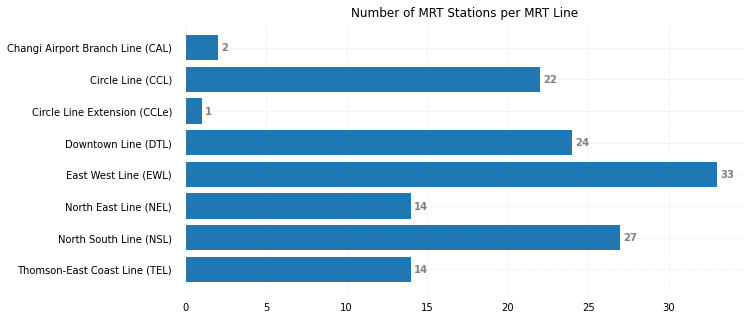

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

#use groupby and nunique to find number of stations per mrt line
no_of_lines = df.groupby('mrt_line')['alpha_numeric_codes'].nunique().reset_index()
mrt_lines = no_of_lines['mrt_line']
no_of_stn = no_of_lines['alpha_numeric_codes']

fig, ax = plt.subplots(figsize = (10, 5))
ax.barh(mrt_lines, no_of_stn)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
ax.set_title('Number of MRT Stations per MRT Line',
             loc ='center', )
plt.show()

In [35]:
#set stations as nodes/pair stations which are immediately next to each other for Djikstra's Algorithm

#subset df
df1 = df[['abbreviation', 'mrt_line']]
df1.columns = ['from', 'mrt_line']
df1['to'] = df1['from'].shift(-1) #shift columns up by 1 to line up subsequent mrt stations from 'from'
#replace values that repeat or are not linked from station to station
df1['to'] = np.where(df1.to.str.contains('PSR'), 'MRB',
                np.where(df1.to.str.contains('XPO'), 'TWR',
                np.where(df1.to.str.contains('HBF'), 'CGA',
                np.where(df1.to.str.contains('DBG'), 'SKG',
                np.where(df1.to.str.contains('BFT'), 'TLB',
                np.where(df1.to.str.contains('BKP'), 'BFT',
                np.where(df1.to.str.contains('WDN'), 'UPC', df1['to'])))))))
df1.iloc[-1, df1.columns.get_loc('to')] = 'UTS' #replace the last incorrect value in last row, last column
df2 = df1
df2 = df2[['to', 'from', 'mrt_line']]
df2.columns = ['from', 'to', 'mrt_line']
df1 = df1[['from', 'to', 'mrt_line']]
station_nodes = pd.concat([df1, df2], ignore_index = True).drop_duplicates().reset_index(drop = True)
display(station_nodes)

C:\Users\Lester\AppData\Local\Temp\ipykernel_25488\3911736280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['to'] = df1['from'].shift(-1) #shift columns up by 1 to line up subsequent mrt stations from 'from'
C:\Users\Lester\AppData\Local\Temp\ipykernel_25488\3911736280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['to'] = np.where(df1.to.str.contains('PSR'), 'MRB',


,from,to,mrt_line
0,JUR,BBT,North South Line (NSL)
1,BBT,BGB,North South Line (NSL)
2,BGB,CCK,North South Line (NSL)
3,CCK,YWT,North South Line (NSL)
4,YWT,KRJ,North South Line (NSL)
...,...,...,...
312,MAX,OTP,East West Line (EWL)
313,SHW,MAX,Thomson-East Coast Line (TEL)
314,MRB,SHW,Thomson-East Coast Line (TEL)
315,GRB,MRB,North South Line (NSL)


In [39]:
# Attempt at Djikstra's Algorithm to calculate shortest path from Sengkang to Ang Mo Kio

from collections import defaultdict
 
def build_graph():
    mrtpaths = station_nodes.reset_index()[['from', 'to']].values.tolist()
    
    graph = defaultdict(list)
     
    for edge in mrtpaths:
        a, b = edge[0], edge[1]

        graph[a].append(b)
        graph[b].append(a)
        
    return graph
 
if __name__ == "__main__":
    graph = build_graph()

def get_shortest_travel_path(graph, from_station, to_station):
    explored = []

    queue = [[from_station]]
     
    if from_station == to_station:
        print("Same station! Please input different stations.")
        return
    
    while queue:
        path = queue.pop(0)
        node = path[-1]
         
        if node not in explored:
            neighbours = graph[node]
             
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                 
                if neighbour == to_station:
                    print("Shortest path = ", *new_path)
                    return
            explored.append(node)
 
    print("So sorry, but a connecting"\
                "path doesn't exist :(")
    return
 
if __name__ == "__main__":
    get_shortest_travel_path(graph, 'SKG', 'AMK')

Shortest path =  SKG BGK HGN KVN SER LRC BSH AMK
